
## Data Preparation

#### Imports and Zip

In [4]:
from zipfile import ZipFile
import cv2
from pathlib import Path
import numpy as np
import os
from datetime import datetime
import io
import imageio
from ipywidgets import widgets, HBox

In [ ]:
def extract_zip(input_zip):
    input_zip=ZipFile(input_zip)
    return {name: input_zip.read(name) for name in input_zip.namelist()}

zip_path = Path(r'C:\Users\Omar\Documents\ShadowMitigation\SKIPPD\CloudMask.zip')
dara = extract_zip(zip_path)

#### Conversion of Image Bytes to np.array

In [2]:
def convert_bytes(img_bytes):
  return  cv2.imdecode(np.frombuffer(img_bytes, dtype=np.uint8), cv2.IMREAD_COLOR)

#### Dataset Preparation and filtering

In [3]:
dataset = {}
for file_name, img_bytes in dara.items():

    x = Path(file_name).stem
    year, month, day, hour, minute = x[:4], x[4:6], x[6:8],x[8:10],x[10:12]

    key = f'{year}-{month}-{day}-{hour}'
    if key not in dataset.keys():
        dataset[key] = []

    dataset[key].append(file_name)

for key, value in dataset.items():
    dataset[key] = sorted(value)

for key, value in dataset.items():
  dataset[key] = [convert_bytes(dara[v]) for v in value]


faulty = []
correct = []
for k, v in dataset.items():
    if len(v) != 60:
        faulty.append(v)
    else:
        correct.append(v)


### Visualize Random Input Tensors

In [71]:
for i in range(5):
  rng = np.random.randint(0,len(correct)-1)
  v = correct[rng]
  input = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in v])[None, ...]
  print(input.shape,rng)
  for video in input[:32]:          # Loop over videos
      with io.BytesIO() as gif:
          imageio.mimsave(gif,video.astype(np.uint8),"GIF",fps=5)
          display(HBox([widgets.Image(value=gif.getvalue())]))


(1, 60, 64, 64) 309


(1, 60, 64, 64) 405


(1, 60, 64, 64) 168


(1, 60, 64, 64) 71


(1, 60, 64, 64) 1030


## Create Dataset Class

In [33]:
import torch
from torch.utils.data import Dataset

In [36]:
class MyCloudDataset(Dataset):

    def __init__(self, X):
          super(MyCloudDataset, self).__init__()
          self.X = np.array(X)

          self.mean = None
          self.std = None
          self.data_name = 'CLOUDS'
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        rand = np.random.randint(15, 45)
        data= self.X[index][rand-15:rand, :, :].transpose(0,3,1,2)
        labels = self.X[index][rand:rand+15, :, :].transpose(0,3,1,2)
        data = torch.tensor(data).float()
        labels = torch.tensor(data).float()
        return data, labels

In [37]:
SKIPPD_SHORT = np.array(correct, dtype=np.float32) / 255  # Ensures the result is float32
np.random.shuffle(SKIPPD_SHORT)  # Shuffles in-place

# Train, Test, Validation splits
train_split = int(0.7 * len(SKIPPD_SHORT))
val_split = int(0.9 * len(SKIPPD_SHORT))

X_train = SKIPPD_SHORT[:train_split]
X_val = SKIPPD_SHORT[train_split:val_split]
X_test = SKIPPD_SHORT[val_split:]


In [38]:
train_set = MyCloudDataset(X=X_train)
val_set = MyCloudDataset(X=X_val)
test_set = MyCloudDataset(X=X_test)

In [49]:
print(test_set.__getitem__(0))
print(test_set.__getitem__(0))

(tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
       

In [40]:
batch_size = 10

dataloader_train = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
dataloader_val = torch.utils.data.DataLoader(
    val_set, batch_size=batch_size, shuffle=True, pin_memory=True)
dataloader_test = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=True, pin_memory=True)

In [43]:
custom_training_config = {
    'pre_seq_length': 15,
    'aft_seq_length': 15,
    'total_length': 15 + 15,
    'batch_size': batch_size,
    'val_batch_size': batch_size,
    'epoch': 20,
    'lr': 0.001,
    'metrics': ['mse', 'mae'],

    'ex_name': 'custom_exp',
    'dataname': 'custom',
    'in_shape': [15,3,64,64],
}


custom_model_config = {
    # For MetaVP models, the most important hyperparameters are:
    # N_S, N_T, hid_S, hid_T, model_type
    'method': 'SimVP',
    # Users can either using a config file or directly set these hyperparameters
    # 'config_file': 'configs/custom/example_model.py',

    # Here, we directly set these parameters
    'model_type': 'gSTA',
    'N_S': 4,
    'N_T': 8,
    'hid_S': 64,
    'hid_T': 256
}

In [44]:
from openstl.utils import create_parser, default_parser

args = create_parser().parse_args([])
config = args.__dict__

# update default parameters
default_values = default_parser()
for attribute in default_values.keys():
    if config[attribute] is None:
        config[attribute] = default_values[attribute]

# update the training config
config.update(custom_training_config)
# update the model config
config.update(custom_model_config)

In [45]:
from openstl.methods import SimVP

PATH = r'C:\Users\Omar\Documents\ShadowMitigation\playground\content\checkpoints\best.ckpt'

model = SimVP(steps_per_epoch=1, 
            test_mean=1, 
            test_std=1, 
            save_dir="", 
            **config)

# Load the checkpoint
checkpoint = torch.load(PATH)  # Ensure it's on the right device

# Load the adjusted state_dict into the model
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

In [56]:
batch = next(iter(dataloader_test))
images = model(batch[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

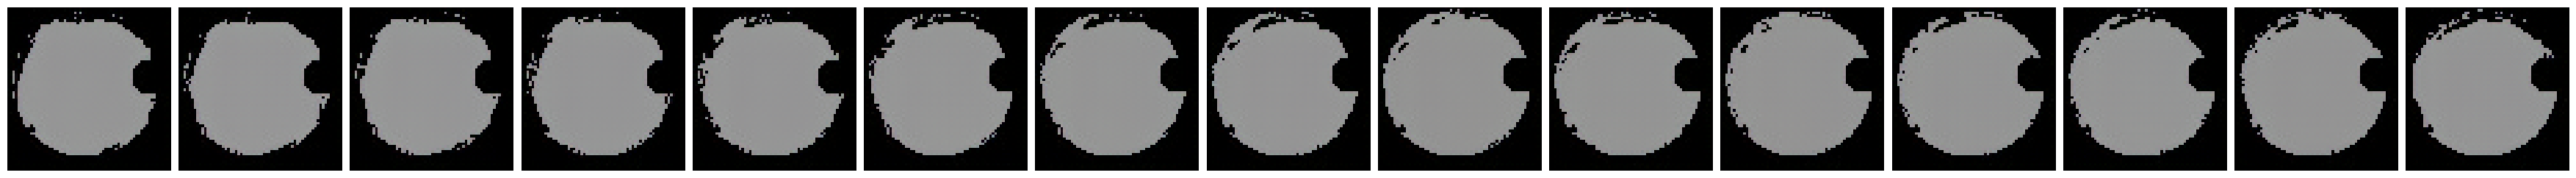

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

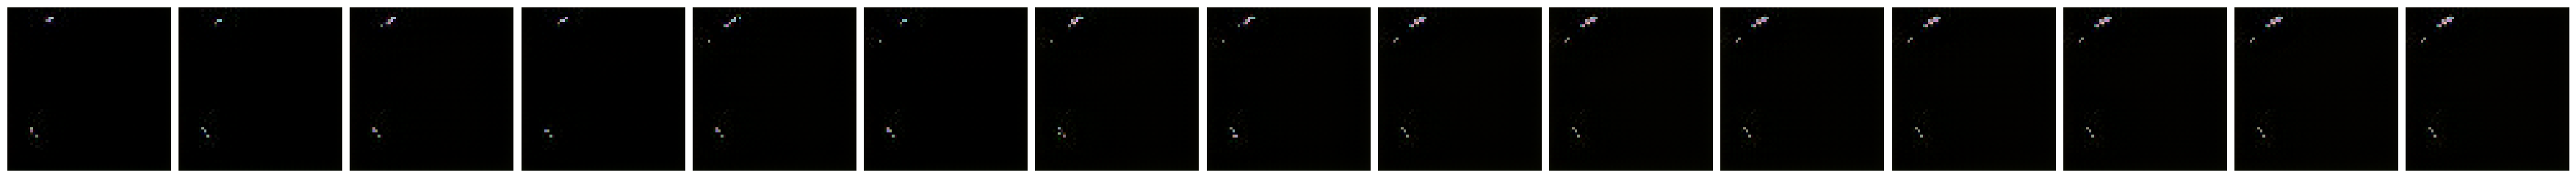

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

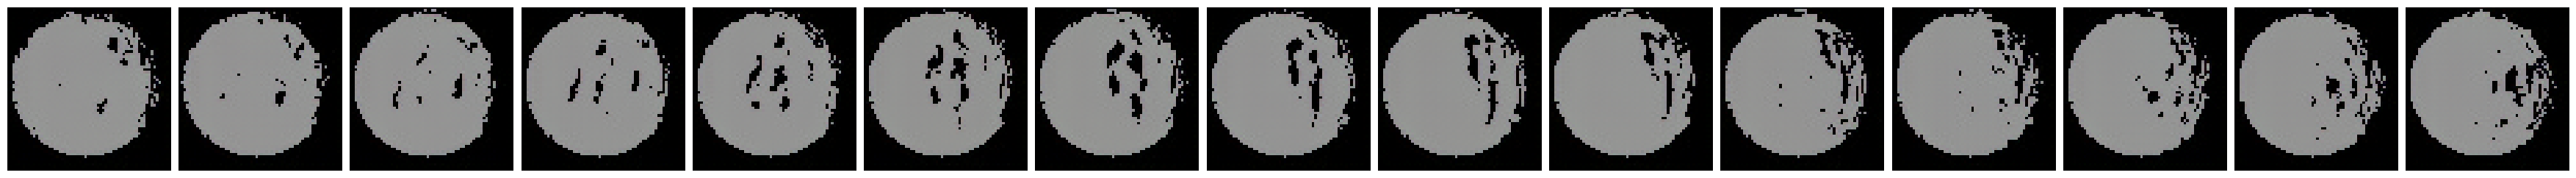

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

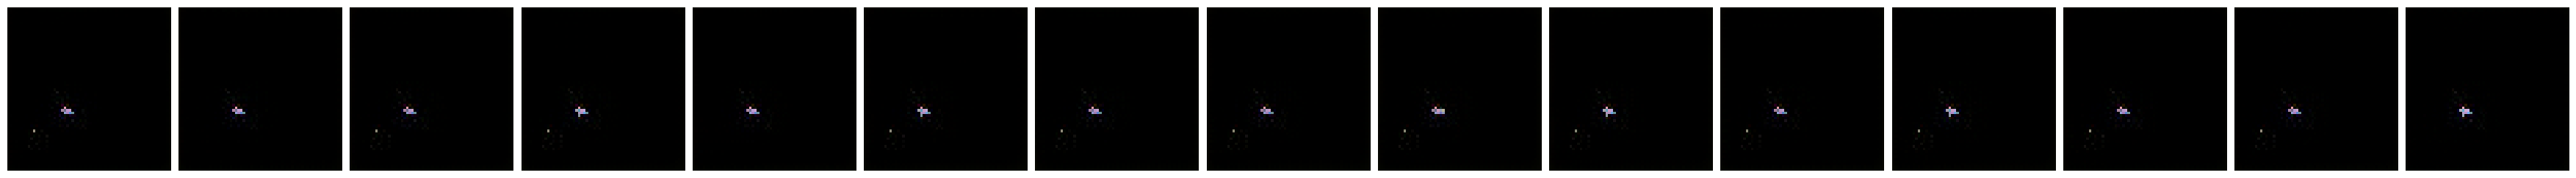

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

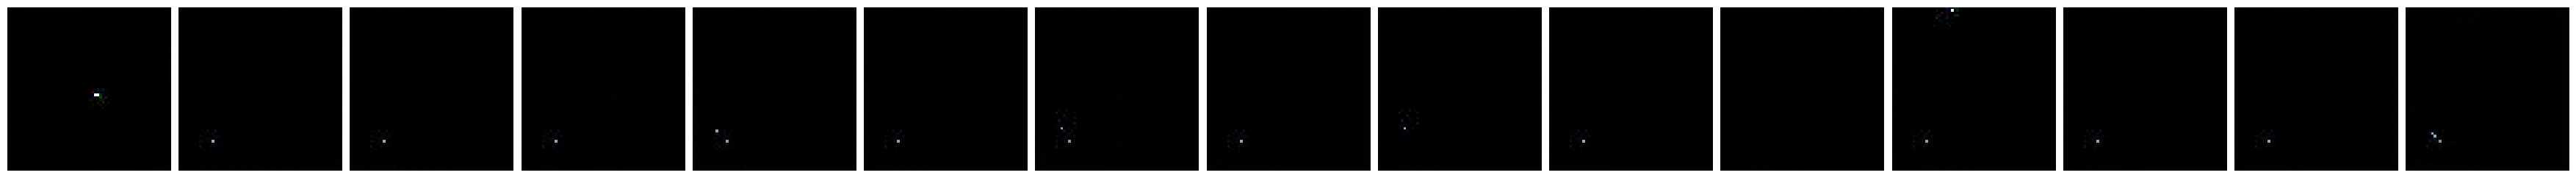

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

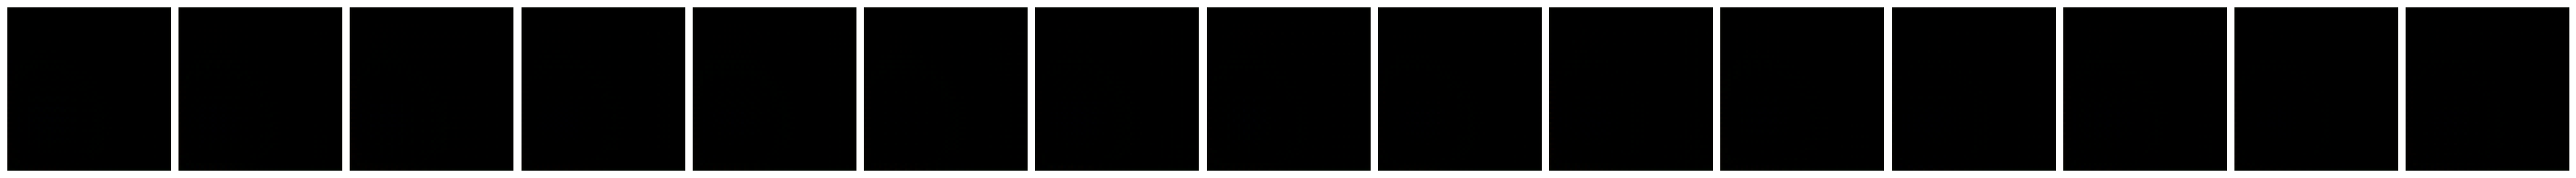

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

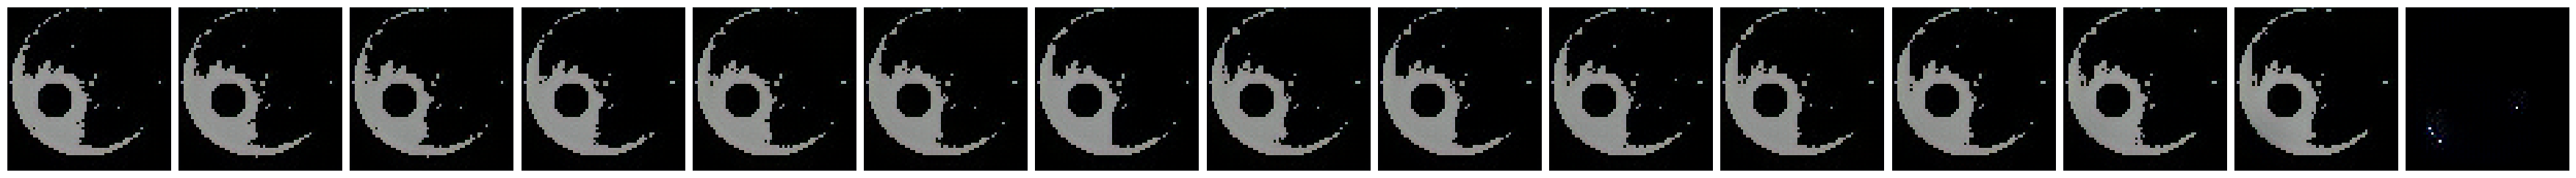

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

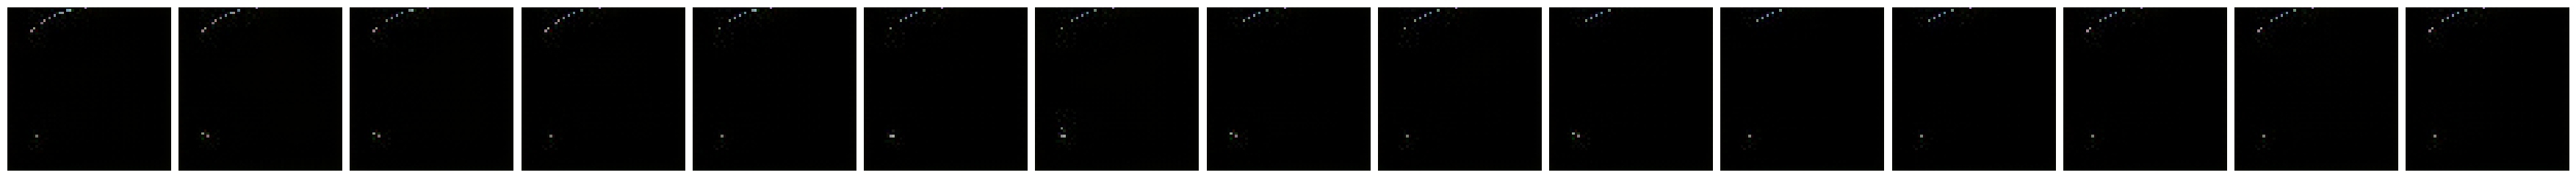

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

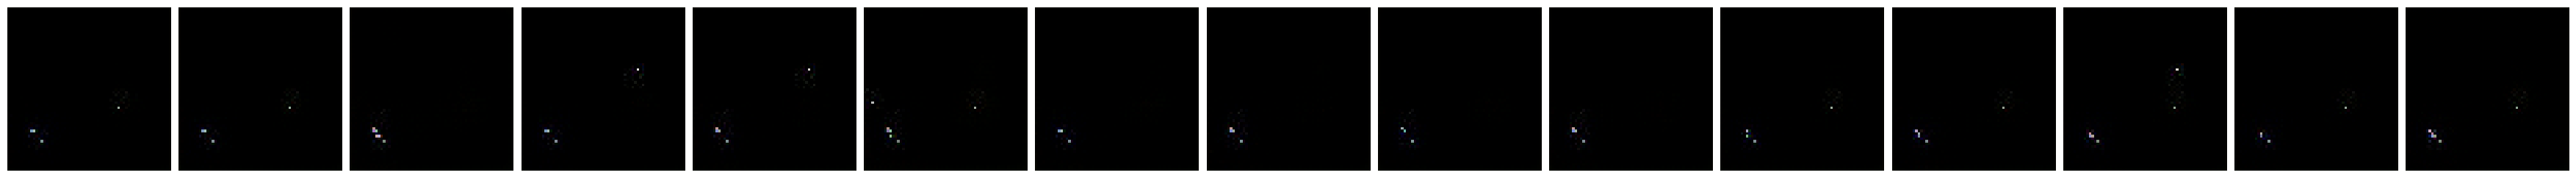

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

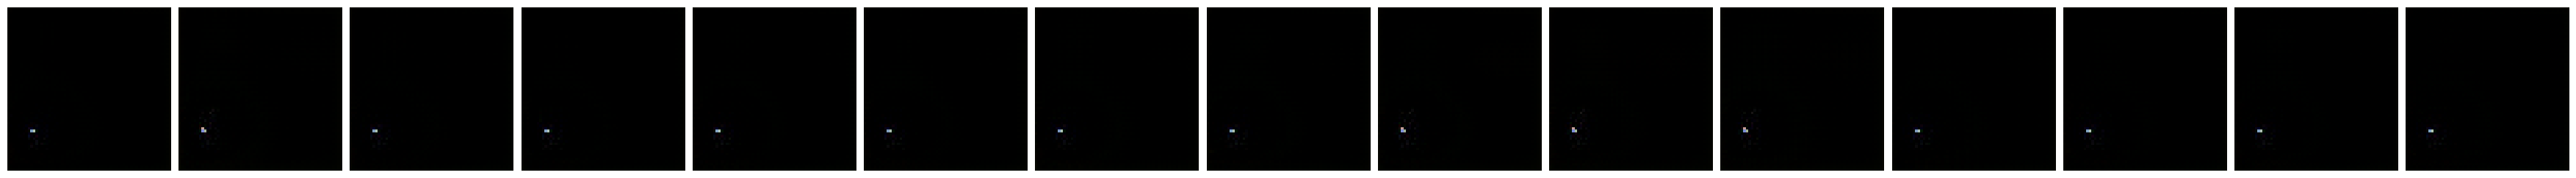

In [77]:
# Function to plot a row of images
def plot_images_row(images, row, axs):
    for i, img in enumerate(images):
        img_np = img.detach().cpu().numpy().transpose((1, 2, 0))
        axs[row, i].imshow(img_np)
        axs[row, i].axis('off')  # Remove axis ticks and labels

# Create a figure to display the images
fig, axs = plt.subplots(2, 15, figsize=(30, 4))  # 2 rows, 15 columns

# Plot true images in the first row
plot_images_row(images_true, 0, axs)

# Plot predicted images in the second row
plot_images_row(images_pred, 1, axs)

plt.subplots_adjust(wspace=0.05, hspace=0.05)  # Adjust the spacing between images
plt.show()